## Opis problemu

**< UZUPEŁNIĆ >**

## Schemat rowiązania

1. Zebranie danych
2. Podział na podzbiór uczący i testowy
3. Usunięcie ze zbioru uczącego źle dzielonych przykładów
4. Wydzielenie i opisanie poszczególnych znaków
5. Wyuczenie modelu do rozpoznawania znaków
6. Sprawdzenie skuteczności na zbiorze testowym

## Pomocnicze funkcje

In [84]:
%pylab inline

import os
import random

from IPython.display import display
import ipywidgets as widgets

from src.CAPTCHA_to_signs import DFS
from src.split_by_DBSCAN import DBScan

import keras

from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import CSVLogger, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [107]:
def prepare_workspace(data_dir_path, alphabet):
    workspace = {d: os.path.join(data_dir_path, d) for d in ['raw', 'invalid', 'train', 'test', 'signs', 'model']}
    workspace['log'] = os.path.join(workspace['model'], 'log')
    
    for dir_path in workspace.values():
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            
    for sign in alphabet:
        sign_dir_path = os.path.join(workspace['signs'], sign)

        if not os.path.exists(sign_dir_path):
            os.makedirs(sign_dir_path)
            
    return workspace

In [18]:
def show_samples(workspace, source='raw', cols=4, rows=3):
    img_dir_path = workspace[source]
    
    img_filenames = random.sample(os.listdir(img_dir_path), cols * rows)
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(15, 5))

    for img_filename, ax in zip(img_filenames, axes.flatten()):
        img_path = os.path.join(img_dir_path, img_filename)
        img = imread(img_path)
        ax.imshow(img)

In [74]:
def split_dataset(workspace, test_ratio=0.3):
    img_dir_path = workspace['raw']
    train_img_dir_path = workspace['train']
    test_img_dir_path = workspace['test']
    
    samples = len(os.listdir(img_dir_path))
    test_samples = int(test_ratio * samples)
    
    progress = widgets.IntProgress(max=samples)
    display(progress)
    
    # Przenieś część do test
    for img_filename in random.sample(os.listdir(img_dir_path), test_samples):
        img_path = os.path.join(img_dir_path, img_filename)

        test_img_path = os.path.join(test_img_dir_path, img_filename)
        os.rename(img_path, test_img_path)
        
        progress.value += 1
        
    # Przenieś pozostałe do train
    for img_filename in os.listdir(img_dir_path):
        img_path = os.path.join(img_dir_path, img_filename)

        train_img_path = os.path.join(train_img_dir_path, img_filename)
        os.rename(img_path, train_img_path)
        
        progress.value += 1
        
    return test_samples, samples - test_samples

In [75]:
def remove_invalid_samples(workspace, splitter):
    img_dir_path = workspace['train']
    invalid_img_dir_path = workspace['invalid']
    
    progress = widgets.IntProgress(max=len(os.listdir(img_dir_path)))
    display(progress)
    
    counter = 0
    for img_filename in os.listdir(img_dir_path):
        img_path = os.path.join(img_dir_path, img_filename)

        label = img_filename.split('.')[0].upper()
        signs = splitter(img_path)

        # Przenieś niepoprawne obrazki do folderu invalid
        if len(label) != len(signs):
            invalid_img_path = os.path.join(invalid_img_dir_path, img_filename)
            os.rename(img_path, invalid_img_path)
            counter += 1
            
        progress.value += 1
            
    return counter

In [76]:
from collections import Counter

def extract_signs(workspace, splitter):
    train_img_dir_path = workspace['train']
    signs_dir_path = workspace['signs']
    
    progress = widgets.IntProgress(max=len(os.listdir(train_img_dir_path)))
    display(progress)
    
    counter = Counter()

    for img_filename in os.listdir(train_img_dir_path):
        img_path = os.path.join(train_img_dir_path, img_filename)

        label = img_filename.split('.')[0].upper()
        signs = splitter(img_path)

        for sign, target in zip(signs, label):
            counter[target] += 1

            sign_path = os.path.join(signs_dir_path, target, str(counter[target]))
            sign.save(sign_path)
            
        progress.value += 1
            
    return counter

In [65]:
def show_signs_stats(signs_stats):
    x = signs_stats.keys()
    y = signs_stats.values()
    
    ind = np.arange(len(x))
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    ax.bar(ind, y)
    
    ax.set_title('Amount of signs')
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x)

In [78]:
def show_sample_sign(workspace, sign):
    signs_dir_path = workspace['signs']
    sign_dir_path = os.path.join(signs_dir_path, sign)

    img_filenames = random.sample(os.listdir(sign_dir_path), 15)
    fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(15, 5))

    for img_filename, ax in zip(img_filenames, axes.flatten()):
        img_path = os.path.join(sign_dir_path, img_filename)
        img = imread(img_path)
        ax.imshow(img, cmap='gray')

In [101]:
def read_data_for_model(workspace, alphabet):
    signs_dir_path = workspace['signs']
    
    X, y = [], []
    
    progress = widgets.IntProgress(max=len(alphabet))
    display(progress)

    for sign in alphabet:
        sign_dir_path = os.path.join(signs_dir_path, sign)

        for img_filename in os.listdir(sign_dir_path):
            img_path = os.path.join(sign_dir_path, img_filename)

            img = image.load_img(img_path, grayscale=True)
            img = image.img_to_array(img)

            X.append(img)
            y.append(sign)
            
        progress.value += 1

    X = np.array(X, dtype='float32') / 255.
    
    encoder = LabelBinarizer()
    y = encoder.fit_transform(np.array(y))
    
    return X, y, encoder

In [97]:
def create_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [125]:
def create_logger_and_checkpoint(workspace, name):
    model_path = workspace['model']
    log_path = workspace['log']
    
    cur_model = name
    csv_logger = CSVLogger(os.path.join(log_path, cur_model + '.log'))

    model_file_name= os.path.join(model_path, cur_model + '-{epoch:03d}-{val_loss:.5f}.h5')
    checkpoint = ModelCheckpoint(model_file_name, verbose=0, save_best_only=True)
    
    return csv_logger, checkpoint

In [210]:
def load_model(workspace, name):
    model_path = workspace['model']
    model_path = os.path.join(model_path, name)
    
    model = keras.models.load_model(model_path)
    return model

In [199]:
def validate_captcha_system(workspace, model, splitter, shape, encoder):
    test_img_dir_path = workspace['test']
    
    progress = widgets.IntProgress(max=len(os.listdir(test_img_dir_path)))
    display(progress)
    
    correct = 0
    invalid_len = 0

    for img_filename in os.listdir(test_img_dir_path):
        img_path = os.path.join(test_img_dir_path, img_filename)

        label = img_filename.split('.')[0].upper()
        signs = splitter(img_path)

        signs = np.array([s.bitmap for s in signs]).reshape(-1, *shape)
        predict = model.predict_classes(signs, verbose=0)

        if len(label) != len(predict):
            invalid_len += 1
        
        if label == ''.join(encoder.classes_[predict]):
            correct += 1
            
        progress.value += 1
        
    samples = len(os.listdir(test_img_dir_path))
            
    return correct * 100. / samples, correct * 100. / (samples - invalid_len)

In [150]:
def show_sample_captcha_solve(workspace, model, splitter, shape, encoder):
    test_img_dir_path = workspace['test']
    
    sample_img_filename = random.choice(os.listdir(test_img_dir_path))
    sample_img_path = os.path.join(test_img_dir_path, sample_img_filename)

    sample_img = imread(sample_img_path)
    
    imshow(sample_img);
    title(sample_img_filename.split('.')[0].upper())
    
    sample_signs = splitter(sample_img_path)
    
    sample_signs_bitmap = np.array([s.bitmap for s in sample_signs]).reshape(-1, *shape)
    predict = model.predict_classes(sample_signs_bitmap, verbose=0)

    fig, axes = plt.subplots(ncols=len(sample_signs))
    for sign, ax, p in zip(sample_signs, axes, encoder.classes_[predict]):
        ax.imshow(sign.bitmap, cmap='gray')
        ax.set_xlabel(p)

## Zbiór danych nr 1

Zbiór ten został wygenerowany na podstawie rozszerzenia do WordPress [Really Simple CAPTCHA](https://wordpress.org/plugins/really-simple-captcha/), które zostało pobrane ponad 1 milion razy. Wszystkie CAPTCHA są długości **4** oraz składają sie z domyślnego alfabetu **'23456789ABCDEFGHJKLMNPQRSTUVWXYZ'** (zostały pominięte znaki np. '1' i 'I', ponieważ są one zbyt podobne do siebie)

Ostatecznie udało się uzyskać **~84.29%** skuteczności

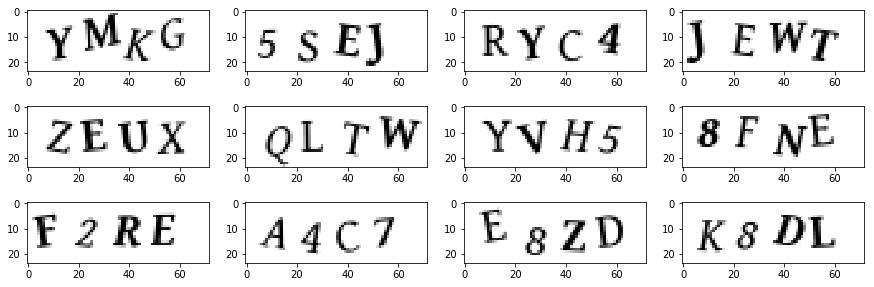

In [203]:
alphabet='23456789ABCDEFGHJKLMNPQRSTUVWXYZ'
workspace = prepare_workspace(os.path.join(os.getcwd(), 'data', 'dataset1'), alphabet)

splitter = lambda path: DFS(path).dfs_all()

show_samples(workspace, source='train')

#### Podziel zestaw na podzbiór testowy i uczący

In [13]:
test_samples, train_samples = split_dataset(workspace)

print 'Test samples:', test_samples
print 'Train samples:', train_samples

Test samples: 2986
Train samples: 6969


#### Usuwamy źle dzielone CAPTCHA ze zbioru trenującego

In [24]:
invalid_samples = remove_invalid_samples(workspace, splitter)

print 'Invalid samples:', invalid_samples

Invalid samples: 1133


#### Z obrazków ze zbioru trenującego wydzielamy znaki i zapisujemy je w odpowiednim katalogu

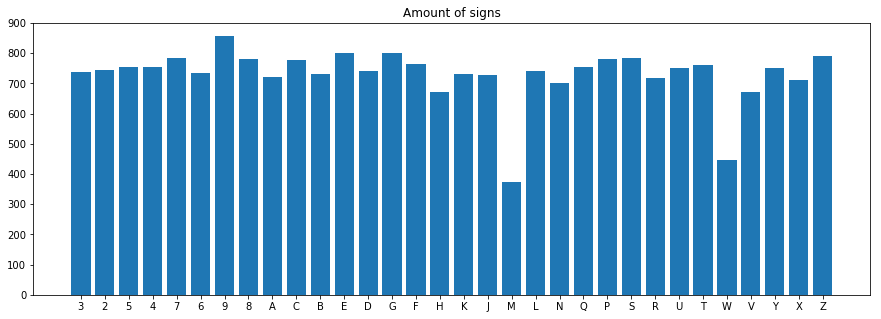

In [67]:
signs_stats = extract_signs(workspace, splitter)

show_signs_stats(signs_stats)

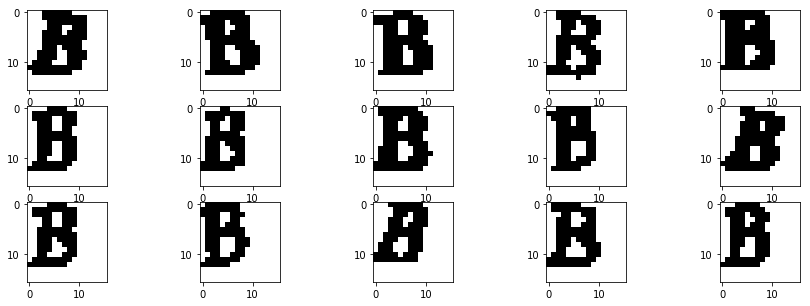

In [82]:
show_sample_sign(workspace, 'B')

#### Tworzenie modelu do rozpoznawania znaków

In [212]:
X, y, encoder = read_data_for_model(workspace, alphabet)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print 'X_train shape:', X_train.shape
print X_train.shape[0], 'train samples'
print X_test.shape[0], 'test samples'

X_train shape: (18675, 16, 16, 1)
18675 train samples
4669 test samples


In [204]:
input_shape = (16, 16, 1)
batch_size = 128

model = create_model(input_shape, num_classes=len(alphabet))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               295040    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

In [112]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#### Sprawdzanie skuteczności modelu na części testowej

In [116]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=5,
          verbose=1,
          validation_data=(X_test, y_test));

Train on 18675 samples, validate on 4669 samples
Epoch 1/5
18675/18675 [==============================] - 1s - loss: 0.0040 - acc: 0.9988 - val_loss: 9.3191e-07 - val_acc: 1.0000
Epoch 2/5
18675/18675 [==============================] - 1s - loss: 0.0037 - acc: 0.9988 - val_loss: 1.3165e-06 - val_acc: 1.0000
Epoch 3/5
18675/18675 [==============================] - ETA: 0s - loss: 0.0040 - acc: 0.998 - 1s - loss: 0.0040 - acc: 0.9988 - val_loss: 1.3044e-06 - val_acc: 1.0000
Epoch 4/5
18675/18675 [==============================] - 1s - loss: 0.0038 - acc: 0.9987 - val_loss: 1.4707e-06 - val_acc: 1.0000
Epoch 5/5
18675/18675 [==============================] - 1s - loss: 0.0047 - acc: 0.9982 - val_loss: 1.2281e-06 - val_acc: 1.0000


In [131]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print 'Test loss:', loss
print 'Test accuracy:', acc

Test loss: 1.26281701724e-07
Test accuracy: 1.0


#### Uczenie modelu na pełym zestawie

In [127]:
csv_logger, checkpoint = create_logger_and_checkpoint(workspace, 'model-full-v1-dataset1')

In [130]:
model.fit(X, y,
          batch_size=batch_size,
          epochs=5,
          verbose=1,
          validation_data=(X, y),
          callbacks=[csv_logger, checkpoint]);

Train on 23344 samples, validate on 23344 samples
Epoch 1/5
23344/23344 [==============================] - 1s - loss: 0.0017 - acc: 0.9994 - val_loss: 1.2506e-07 - val_acc: 1.0000
Epoch 2/5
23344/23344 [==============================] - 1s - loss: 0.0015 - acc: 0.9996 - val_loss: 1.2382e-07 - val_acc: 1.0000
Epoch 3/5
23344/23344 [==============================] - 1s - loss: 0.0018 - acc: 0.9993 - val_loss: 1.4567e-07 - val_acc: 1.0000
Epoch 4/5
23344/23344 [==============================] - 1s - loss: 0.0012 - acc: 0.9995 - val_loss: 1.2519e-07 - val_acc: 1.0000
Epoch 5/5
23344/23344 [==============================] - 1s - loss: 0.0017 - acc: 0.9995 - val_loss: 1.2441e-07 - val_acc: 1.0000


In [211]:
model = load_model(workspace, 'model-full-v1-dataset1-009-0.00000.h5')

### Testowanie systemu na zbiorze testowym CAPTCHA

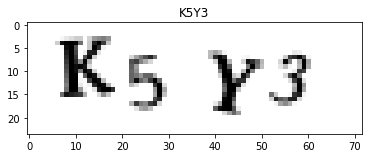

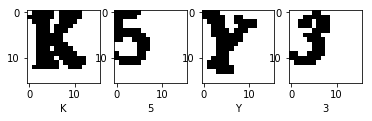

In [213]:
show_sample_captcha_solve(workspace, model, splitter, input_shape, encoder)

In [214]:
acc, acc_len = validate_captcha_system(workspace, model, splitter, input_shape, encoder)

print 'Test CAPTCHA dataset accuracy: {}%'.format(acc)
print 'Test CAPTCHA dataset with good split accuracy: {}%'.format(acc_len)

Test CAPTCHA dataset accuracy: 84.2933690556%
Test CAPTCHA dataset with good split accuracy: 100.0%


## Zbiór danych nr 2

Zestaw ten został wygenerowany przy użyciu http://captchas.net/. Wszystkie CAPTCHA są długości **6** oraz składają sie z domyślnego alfabetu **'23456789abcdefghjklmnpqrstuvwxyz'**

Ostatecznie udało się osiągnąć **~%** dokładności

In [176]:
alphabet='23456789ABCDEFGHJKLMNPQRSTUVWXYZ'
letters = 6
workspace = prepare_workspace(os.path.join(os.getcwd(), 'data', 'dataset2'), alphabet)

splitter = lambda path: DBScan(path, min_samples=8).dbscan()

#### Generowanie zbioru danych

In [160]:
import src.CaptchasDotNet as CaptchasDotNet

In [161]:
from IPython.display import Image, display
from IPython.core.display import HTML 

def show_sample_captchasdotnet(alphabet, letters):
    alphabet = alphabet.lower()
    captchas = CaptchasDotNet.CaptchasDotNet(client='demo', secret='secret', alphabet=alphabet, letters=letters)
    
    captchas.random()

    display(Image(url= captchas.image_url()))
    print captchas.password()

In [167]:
import urllib
from time import sleep

def captchasdotnet_generate(workspace, alphabet, letters, samples):
    img_dir_path = workspace['raw']
    
    alphabet = alphabet.lower()
    captchas = CaptchasDotNet.CaptchasDotNet(client='demo', secret='secret', alphabet=alphabet, letters=letters)
    
    progress = widgets.IntProgress(max=samples)
    display(progress)

    for i in range(samples):
        captchas.random()

        image_url = captchas.image_url().replace('&amp;', '&')
        label = captchas.password()

        img_path = os.path.join(img_dir_path, '{}.png'.format(label))

        urllib.urlretrieve(image_url, img_path)

        progress.value += 1

        if i % 10 == 0:
            sleep(1)
            
    return len(os.listdir(img_dir_path))

In [168]:
show_sample_captchasdotnet(alphabet, 6)

tsyu93


In [174]:
samples = captchasdotnet_generate(workspace, alphabet, letters, 4900)

print samples, 'samples in dataset2/raw'

10000 samples in dataset2/raw


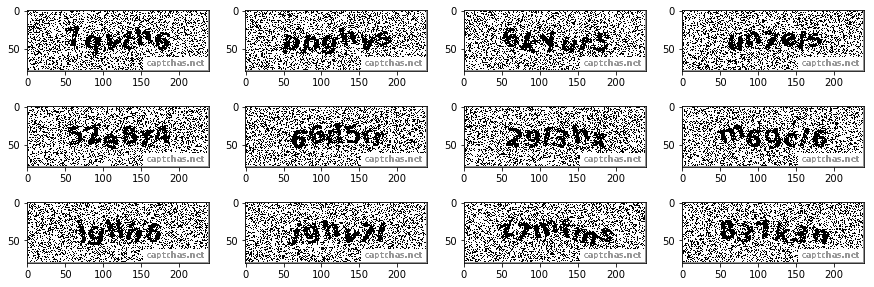

In [172]:
show_samples(workspace, source='raw')

#### Podziel zestaw na podzbiór testowy i uczący


In [175]:
test_samples, train_samples = split_dataset(workspace, test_ratio=0.3)

print 'Test samples:', test_samples
print 'Train samples:', train_samples

Test samples: 3000
Train samples: 7000


#### Usuwamy źle dzielone CAPTCHA ze zbioru trenującego

In [177]:
invalid_samples = remove_invalid_samples(workspace, splitter)

print 'Invalid samples:', invalid_samples

Invalid samples: 3895


#### Z obrazków ze zbioru trenującego wydzielamy znaki i zapisujemy je w odpowiednim katalogu

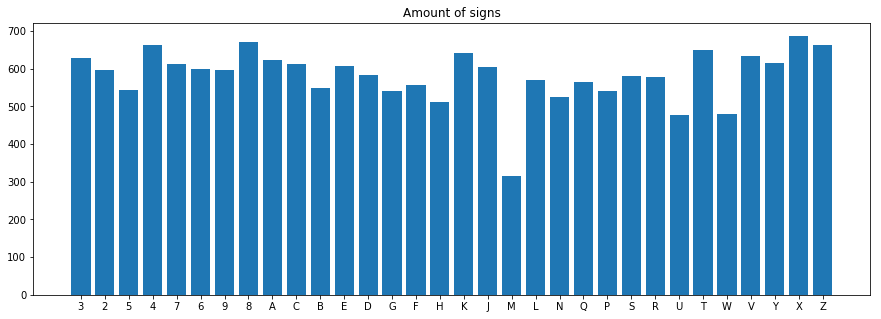

In [178]:
signs_stats = extract_signs(workspace, splitter)

show_signs_stats(signs_stats)

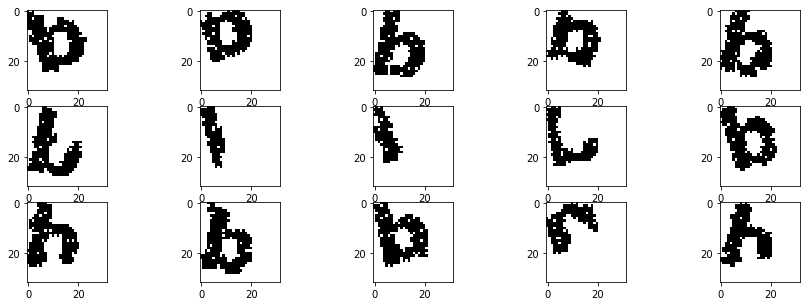

In [179]:
show_sample_sign(workspace, 'B')

#### Tworzenie modelu do rozpoznawania znaków

In [180]:
X, y, encoder = read_data_for_model(workspace, alphabet)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print 'X_train shape:', X_train.shape
print X_train.shape[0], 'train samples'
print X_test.shape[0], 'test samples'

X_train shape: (14904, 32, 32, 1)
14904 train samples
3726 test samples


In [181]:
input_shape = (32, 32, 1)
batch_size = 128

model = create_model(input_shape, num_classes=len(alphabet))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [193]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#### Sprawdzanie skuteczności modelu na części testowej

In [191]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=5,
          verbose=1,
          validation_data=(X_test, y_test));

Train on 14904 samples, validate on 3726 samples
Epoch 1/5
14904/14904 [==============================] - 1s - loss: 0.3229 - acc: 0.9003 - val_loss: 1.2949 - val_acc: 0.7858
Epoch 2/5
14904/14904 [==============================] - 1s - loss: 0.3295 - acc: 0.8969 - val_loss: 1.2875 - val_acc: 0.7861
Epoch 3/5
14904/14904 [==============================] - 1s - loss: 0.3180 - acc: 0.8997 - val_loss: 1.2950 - val_acc: 0.7869
Epoch 4/5
14904/14904 [==============================] - 1s - loss: 0.3192 - acc: 0.9044 - val_loss: 1.2933 - val_acc: 0.7866
Epoch 5/5
14904/14904 [==============================] - 1s - loss: 0.3182 - acc: 0.9011 - val_loss: 1.2945 - val_acc: 0.7866


In [192]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print 'Test loss:', loss
print 'Test accuracy:', acc

Test loss: 1.29447530241
Test accuracy: 0.786634460707


#### Uczenie modelu na pełym zestawie

In [194]:
csv_logger, checkpoint = create_logger_and_checkpoint(workspace, 'model-full-v1-dataset2')

In [195]:
model.fit(X, y,
          batch_size=batch_size,
          epochs=5,
          verbose=1,
          validation_data=(X, y),
          callbacks=[csv_logger, checkpoint]);

Train on 18630 samples, validate on 18630 samples
Epoch 1/5
18630/18630 [==============================] - 3s - loss: 0.6467 - acc: 0.8459 - val_loss: 0.3306 - val_acc: 0.9359
Epoch 2/5
18630/18630 [==============================] - 3s - loss: 0.6084 - acc: 0.8513 - val_loss: 0.3280 - val_acc: 0.9401
Epoch 3/5
18630/18630 [==============================] - 3s - loss: 0.5894 - acc: 0.8545 - val_loss: 0.3061 - val_acc: 0.9418
Epoch 4/5
18630/18630 [==============================] - 2s - loss: 0.5802 - acc: 0.8577 - val_loss: 0.3134 - val_acc: 0.9470
Epoch 5/5
18630/18630 [==============================] - 3s - loss: 0.5689 - acc: 0.8587 - val_loss: 0.2870 - val_acc: 0.9388


### Testowanie systemu na zbiorze testowym CAPTCHA

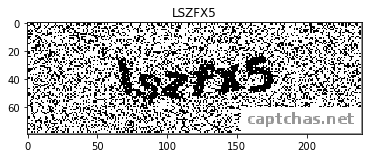

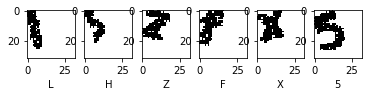

In [196]:
show_sample_captcha_solve(workspace, model, splitter, input_shape, encoder)

In [202]:
acc, acc_len = validate_captcha_system(workspace, model, splitter, input_shape, encoder)

print 'Test CAPTCHA dataset accuracy: {}%'.format(acc)
print 'Test CAPTCHA dataset with good split accuracy: {}%'.format(acc_len)

Test CAPTCHA dataset accuracy: 13.9333333333%
Test CAPTCHA dataset with good split accuracy: 30.8943089431%
